In [14]:
import numpy as np
from librosa.core import stft
import matplotlib.pyplot as plt
from librosa.filters import mel

from time import time

# Librosa

In [15]:
data = np.load("waveform_x.np.npy")

# np.random.seed(3)
# y = np.sin(2*np.pi*50*np.linspace(0,10,2048))+np.sin(2*np.pi*20*np.linspace(0,10,2048)) + np.random.normal(scale=1,size=2048)


In [16]:
MelSpec_list = []
S_stft_list = []
start = time()
for song in data:
    S_stft = np.abs(stft(song, hop_length=512, n_fft=2048,center=False))
    mel_basis = mel(44100, 2048)
    MelSpec = np.dot(mel_basis, S_stft**2)
    MelSpec_list.append(MelSpec)
    S_stft_list.append(S_stft)
print("Processing finished, {0:.3f}s used".format(time()-start))

Processing finished, 0.730s used


Text(0.5, 1.0, 'Mel Spec output')

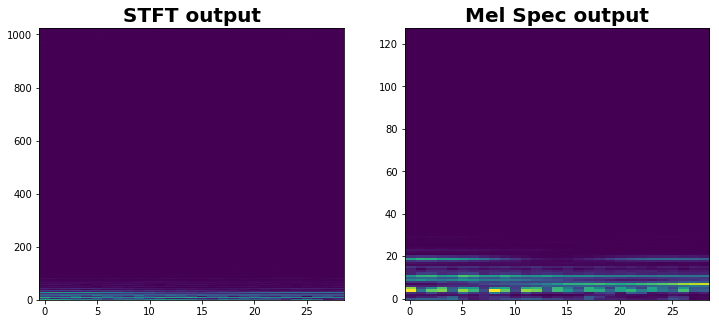

In [17]:
img_idx = 1

fig, ax = plt.subplots(1,2, figsize=(12,5))
# ax[0].plot(S_stft)
ax[0].imshow(S_stft_list[img_idx], aspect="auto")
ax[0].invert_yaxis()
ax[0].set_title("STFT output", size=20, fontweight="bold")

# ax[1].plot(MelSpec)
ax[1].imshow(MelSpec_list[img_idx], aspect="auto")
ax[1].invert_yaxis()
ax[1].set_title("Mel Spec output", size=20, fontweight="bold")

# Pytorch

In [5]:
import torch
from torch.autograd import Variable
from torch.nn.functional import conv1d

from scipy.signal.windows import hann

stride = 512

def create_filters(d,k,low=50,high=6000):
    x = np.arange(0, d, 1)
    wsin = np.empty((k,1,d), dtype=np.float32)
    wcos = np.empty((k,1,d), dtype=np.float32)
    start_freq = low
    end_freq = high
    # num_cycles = start_freq*d/44000.
    # scaling_ind = np.log(end_freq/start_freq)/k

    window_mask = hann(2048, sym=False) # same as 0.5-0.5*np.cos(2*np.pi*x/(k))
    for ind in range(k):
        wsin[ind,0,:] = window_mask*np.sin(2*np.pi*ind/k*x)
        wcos[ind,0,:] = window_mask*np.cos(2*np.pi*ind/k*x)

    return wsin,wcos

wsin, wcos = create_filters(2048,2048)

wsin_var = Variable(torch.from_numpy(wsin), requires_grad=False)
wcos_var = Variable(torch.from_numpy(wcos),requires_grad=False)

start = time()
batch_size = data.shape[0]
network_input = torch.from_numpy(data).float()
network_input = network_input.reshape(batch_size,-1)

zx = np.sqrt(conv1d(network_input[:,None,:], wsin_var, stride=stride).pow(2)+conv1d(network_input[:,None,:], wcos_var, stride=stride).pow(2))
torch_mel_basis = torch.from_numpy(mel_basis).float() # Need to think how to implement it natively inside pytorch
torch_MelSpec = torch.matmul(torch_mel_basis, zx.reshape(batch_size,2048,-1)[:,:1025]**2) # Need to figure out 3D tensor operation

pytorch_Xs = zx.cpu().numpy()
print("Processing finished, {0:.3f}s used".format(time()-start))

Processing finished, 0.202s used


Text(0.5, 1.0, 'Mel Spec output')

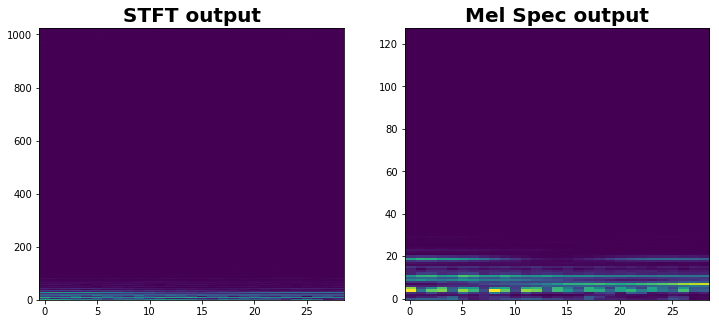

In [7]:
img_idx = 1

fig, ax = plt.subplots(1,2, figsize=(12,5))
# ax[0].plot(pytorch_Xs[0,:1025,0])
ax[0].imshow(pytorch_Xs[img_idx,:1025,:],aspect="auto")
ax[0].set_title("STFT output", size=20, fontweight="bold")
ax[0].invert_yaxis()

# ax[1].plot(torch_MelSpec.cpu().numpy())
ax[1].imshow(torch_MelSpec[img_idx].cpu().numpy(),aspect="auto")
ax[1].invert_yaxis()
ax[1].set_title("Mel Spec output", size=20, fontweight="bold")

In [11]:
img_idx = 1

In [12]:
np.allclose(MelSpec_list[img_idx], torch_MelSpec[img_idx].cpu().numpy())

True

In [13]:
np.allclose(S_stft_list[img_idx], pytorch_Xs[img_idx,:1025,:], atol=1e-5)

True